In [106]:
import pandas as pd

In [107]:
abtour = pd.read_csv('data/ab_data_tourist.csv')
abtour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [108]:
abtour['date'] = pd.to_datetime(abtour['date'])
abtour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


In [109]:
abtour.groupby('group')['date'].agg(['min', 'max'])
abtour['date'].min()


Timestamp('2021-01-02 00:00:00')

In [110]:
abtour['date'].max()

Timestamp('2021-01-24 00:00:00')

In [111]:
abtour['group'].value_counts()

B    147276
A    147202
Name: group, dtype: int64

In [112]:
group_a = abtour[abtour['group'] == 'A']
group_b = abtour[abtour['group'] == 'B']
group_a['purchase'].value_counts()

0    129479
1     17723
Name: purchase, dtype: int64

In [113]:
group_b['purchase'].value_counts()

0    129762
1     17514
Name: purchase, dtype: int64

In [114]:
group_a['price'].sum()

1436260000

In [115]:
group_b['price'].sum()

1554100000

In [116]:
duplicates = set(group_a['user_id']).intersection(set(group_b['user_id']))
len(duplicates)

1895

In [117]:
newab = abtour[abtour['user_id'].apply(lambda x: x not in duplicates)]
newab.value_counts()

user_id  date        group  purchase  price
756382   2021-01-06  B      0         0        2
793692   2021-01-15  A      0         0        2
692249   2021-01-20  A      0         0        2
781820   2021-01-22  B      0         0        2
838889   2021-01-06  A      0         0        2
                                              ..
735265   2021-01-03  A      0         0        1
735267   2021-01-23  B      0         0        1
735268   2021-01-10  A      0         0        1
735270   2021-01-23  A      0         0        1
945999   2021-01-16  B      0         0        1
Length: 290614, dtype: int64

In [118]:
sumab = newab.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id':'count_visits', 'purchase':'count_purchases', 'price':'sum_price'})
sumab

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


***
Предварительные выводы:
На данном этапе мы не можем сделать никаких выводов. На первый взгляд данные выглядят примерно одинаково. Группы сбалансированны.
***

In [119]:
sumab['conversion'] = round(sumab['count_purchases'] / sumab['count_visits']*100, 2)
sumab['mean_check'] = round(sumab['sum_price']/sumab['count_purchases'])
sumab

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


***
Выводы:
Из данной таблицы мы видим, что конверсия в первой группе незначительно превышает конверсию во второй группе, однако средний чек во второй группе выше, чем в первой.
***

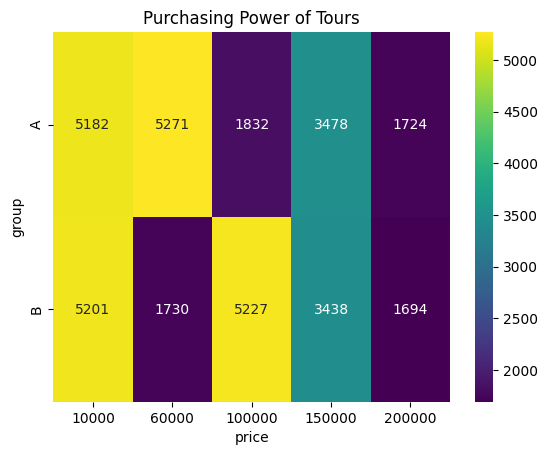

In [120]:
import matplotlib as plt
import seaborn as sns
pivot_table = newab[newab['price'] > 0].pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum'
)

fig = sns.heatmap(pivot_table, fmt='.0f', annot=True, cmap='viridis');
fig.set_title('Purchasing Power of Tours');

***
Выводы:
Как мы можем заметить по тепловой карте, существует заметное различие в покупаемых турах в зависимости от группы. Если представители первой группы в большинстве своём приобретают туры в Турцию, то представители второй группы предпочитают Таиланд.
***

In [121]:
daily_data = newab.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'users_count', 'price': 'revenue'})
daily_data['conversion'] = round(daily_data['purchase']/daily_data['users_count']*100, 2)
daily_data['av_bill'] = round(daily_data['revenue']/daily_data['purchase'])
daily_data.head()

,date,group,users_count,purchase,revenue,conversion,av_bill
0,2021-01-02,A,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0


In [122]:
daily_data['cum_users_count'] = daily_data.groupby('group')['users_count'].cumsum()
daily_data['cum_purchase'] = daily_data.groupby('group')['purchase'].cumsum()
daily_data['cum_revenue'] = daily_data.groupby('group')['revenue'].cumsum()
daily_data['cum_conversion'] = round(daily_data['cum_purchase']/daily_data['cum_users_count']*100, 2)
daily_data['cum_av_bill'] = round(daily_data['cum_revenue']/daily_data['cum_purchase'])
daily_data.loc[20]

date               2021-01-12 00:00:00
group                                A
users_count                       6540
purchase                           795
revenue                       68460000
conversion                       12.16
av_bill                        86113.0
cum_users_count                  68852
cum_purchase                      8198
cum_revenue                  668070000
cum_conversion                   11.91
cum_av_bill                    81492.0
Name: 20, dtype: object

In [123]:
daily_data.loc[37]

date               2021-01-20 00:00:00
group                                B
users_count                       6685
purchase                           790
revenue                       69250000
conversion                       11.82
av_bill                        87658.0
cum_users_count                 121857
cum_purchase                     14496
cum_revenue                 1286900000
cum_conversion                    11.9
cum_av_bill                    88776.0
Name: 37, dtype: object

Text(0.5, 1.0, 'Cumulative Conversion')

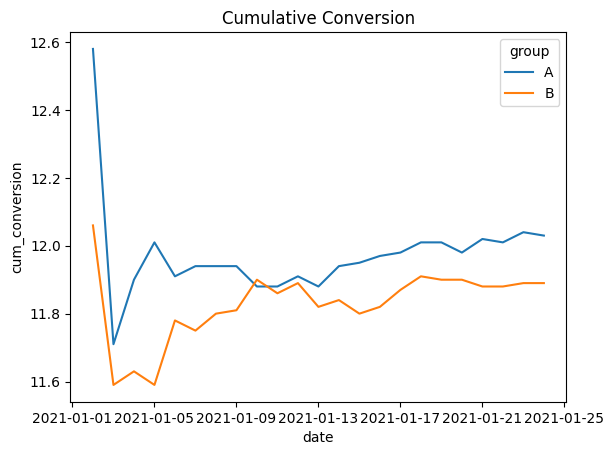

In [124]:
sns.lineplot(data=daily_data, x='date', y='cum_conversion', hue='group').set_title('Cumulative Conversion')

Text(0.5, 1.0, 'Cumulative Revenue')

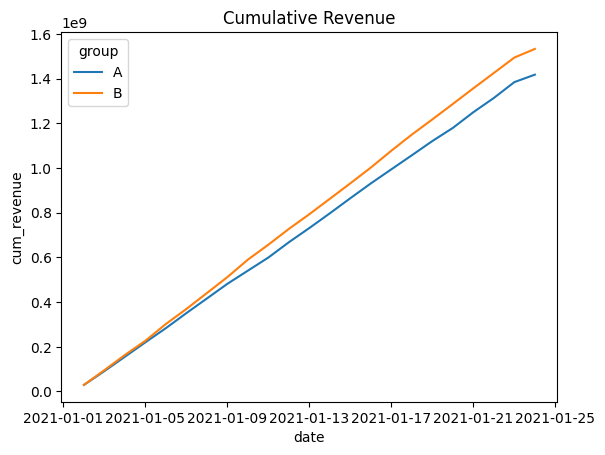

In [125]:
sns.lineplot(data=daily_data, x='date', y='cum_revenue', hue='group').set_title('Cumulative Revenue')

***
Выводы:
Ожидаемо в первый день коверсия в обеих группах значительно выше, чем в последующие дни. После первого дня происходит резкое падение, затем график выравнивается. В целом, как и говорилось ранее, конверсия в первой группе почти во все дни превышает конверсию во второй группе.
График кумулятивной выручки выглядит максимально ровным. Выручка вы второй группе незначительно превышает выручку в первой группе.
***

In [126]:
from statsmodels.stats.proportion import proportions_ztest

In [127]:
converted_piv= newab.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17487,145307
B,17290,145381


In [128]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05
_, p_value = proportions_ztest(
    count=converted_piv['sum'],
    nobs=converted_piv['count'],
    alternative='larger',
)
print('p-value: ', round(p_value, 2))
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу: {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу: {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу: Конверсии в группах А и B равны


***
Выводы:
Согласно результатам статистического теста, статистическая разница между двумя группами отсутствует. Это заметно и из графика конверсии.
***

In [129]:
group_a = newab[newab['group'] == 'A']
group_b = newab[newab['group'] == 'B']

In [130]:
from scipy.stats import norm

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 
    lower_bound = x_p - eps 
    upper_bound = x_p + eps
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [131]:
a_int = proportions_conf_interval(group_a['user_id'].count(), group_a['purchase'].mean(), gamma=0.95)
a_int

(11.87, 12.2)

In [132]:
b_int = proportions_conf_interval(group_b['user_id'].count(), group_b['purchase'].mean(), gamma=0.95)
b_int

(11.73, 12.06)

In [133]:
def diff_conversion_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma 
    diff = xp[1] - xp[0] 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 
    lower_bound = diff - eps 
    upper_bound = diff + eps 
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [134]:
n = [group_a['user_id'].count(), group_b['user_id'].count()]
xp = [group_a['purchase'].mean(), group_b['purchase'].mean()]

diff_inverval = diff_conversion_conf_interval(n, xp)
diff_inverval

(-0.38, 0.09)

***
Выводы:
Как мы видим из построения доверительных интервалов, доверительный интервал группы А полностью перекрывает доверительный интервал группы В, что не даёт нам однозначного ответа о разнице в конверсиях. А поскольку доверительный интервал разницы охватывает точку 0, мы можем с 95% уверенностью сказать, что разница в конверсии может быть как положительной, так и отрицательной. Это лишь означает, что обе группы равнозначны по метрике конверсии. 
***

In [135]:
from scipy.stats import shapiro
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05
 
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']
 
shapiro_result_a = shapiro(daily_data_a['av_bill'])
shapiro_result_b = shapiro(daily_data_b['av_bill'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу: {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу: Распределения в обеих группах нормальные


In [136]:
from scipy.stats import ttest_ind
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05

 
results = ttest_ind(
    daily_data_a['av_bill'],
    daily_data_b['av_bill'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу: {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу: Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


***
Выводы:
Что касается среднего чека, то здесь всё предельно однозначно. В группе В он пусть и незначительно, но всё-таки выше. Это видно как из графика, так и из итогов статистического теста.
***

In [137]:
daily_data_a.head()

,date,group,users_count,purchase,revenue,conversion,av_bill,cum_users_count,cum_purchase,cum_revenue,cum_conversion,cum_av_bill
0,2021-01-02,A,2854,359,29410000,12.58,81922.0,2854,359,29410000,12.58,81922.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0,9450,1107,91410000,11.71,82575.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0,16016,1906,155660000,11.90,81668.0
6,2021-01-05,A,6433,790,64550000,12.28,81709.0,22449,2696,220210000,12.01,81680.0
8,2021-01-06,A,6606,764,63410000,11.57,82997.0,29055,3460,283620000,11.91,81971.0


In [138]:
def conf_int2(n, x_mean, x_std, gamma=0.95):
    k = n - 1
    alpha = 1 - gamma
    from scipy.stats import t
    t_crit = -t.ppf(alpha/2, k)
    eps = t_crit * x_std/(n ** 0.5)
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps
    confidence_interval = (round(lower_bound), round(upper_bound))
    return (t_crit, confidence_interval)

In [139]:
a_crit = conf_int2(daily_data_a['users_count'].count(), daily_data_a['av_bill'].mean(), daily_data_a['av_bill'].std())
a_crit

(2.0738730679040147, (79630, 82308))

In [140]:
b_crit = conf_int2(daily_data_b['users_count'].count(), daily_data_b['av_bill'].mean(), daily_data_b['av_bill'].std())
b_crit

(2.0738730679040147, (87626, 89526))

***
Выводы:
Поскольку нижняя граница доверительного интервала истинного среднего чека второй группы выше верхней границы доверительного интервала первой группы, можно с уверенностью сказать, что средний чек во второй группе выше, чем в первой. Это было хорошо заметно как из визуализации данных, так и из статистических тестов.
***

***
Общий вывод:
Исходя из проделанной работы, можно сказать, что данные разных групп имеют свои различия. Вероятно посадочная страница, что была предложена первой группе каким-то образом влияет на выбор тура в Турцию, а та, что была предложена второй группе настраивает людей на отпуск в Таиланде. Но это уже отдельная история.
По итогу можно сказать, что с одной стороны, всё однозначно, средний чек во второй группе превышает средний чек в первой группе, однако не стоит забывать, что тур в Таиланд неспроста стоит дороже Турецкого тура. Расходы компании на такой тур будут тоже соответственно выше, а учитывая тот факт, что конверсия в первой группе согласно визуализации, как-никак, превышает конверсию во второй группе, вопрос о преимуществе в доходах компании остаётся открытым.
***